In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

import sklearn.metrics as metrics

from scRNA.simulation import generate_toy_data, split_source_target
from scRNA.nmf_clustering import NmfClustering_initW, NmfClustering, DaNmfClustering
from scRNA.sc3_clustering_impl import data_transformation_log2

In [2]:
n_genes = 1000
n_cells = 4000
n_trg = 50
n_src = 500
cluster_spec = [1, 2, 3, [4, 5], [6, [7, 8]]]

In [24]:
np.random.seed(42)
data, labels = generate_toy_data(num_genes=n_genes, 
                                 num_cells=n_cells,
                                 cluster_spec=cluster_spec)
print(data.shape)
# data = data_transformation_log2(data)

(1000, 4000)


0 63


Text(0,0.5,'Genes')

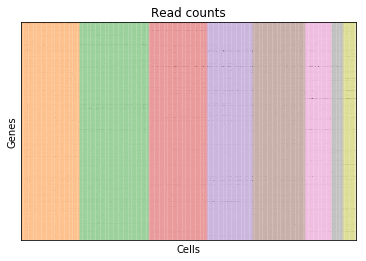

In [4]:
plt.figure(0)
print(np.min(data), np.max(data))
inds = np.argsort(labels)
plt.pcolor(data[:, inds] / np.max(data), cmap='Greys')
plt.clim(0.,+1.)
plt.xticks([])
plt.yticks([])
for i in range(len(labels)):
    plt.vlines(i, 0, n_genes, colors='C{0}'.format(labels[inds[i]]), alpha=0.15)
plt.title('Read counts')
plt.xlabel('Cells')
plt.ylabel('Genes')

In [25]:
np.random.seed(1)
data_source, data_target, true_labels_source, true_labels_target = \
    split_source_target(
        data,
        labels,
        target_ncells = n_trg,
        source_ncells = n_src,
        source_clusters = [1,2,3],
        mode = 6,
        common = 0,
        cluster_spec = cluster_spec
    )

trg_labels = np.unique(true_labels_target)
src_labels = np.unique(true_labels_source)
print(np.unique(true_labels_source))
print(np.unique(true_labels_target))

[1 2 3]
[1 2 3 4 5 6 7 8]


In [26]:
np.random.seed(1)
nmf = NmfClustering_initW(data_source.copy(), np.arange(n_genes), labels=true_labels_source, num_cluster=src_labels.size)
nmf.apply(alpha=1., l1=0.75, rel_err=1e-8)
# nmf.print_reconstruction_error(data_source, nmf.dictionary, nmf.data_matrix)
metrics.adjusted_rand_score(true_labels_source, nmf.cluster_labels)

1.0

In [28]:
np.random.seed(1)
da_nmf_target = DaNmfClustering(nmf, data_target.copy(), np.arange(n_genes), num_cluster=trg_labels.size)
thetas = np.linspace(0, 1, 10)
res = np.zeros(thetas.size)
for i in range(thetas.size):
    da_nmf_target.apply(mix=thetas[i], alpha=1., l1=0.75, rel_err=1e-8, calc_transferability=False)
    # print(da_nmf_target.cluster_labels)
    res[i] = metrics.adjusted_rand_score(true_labels_target, da_nmf_target.cluster_labels)
    print(i, res[i])

0 0.690384363357
1 0.923354757977
2 0.944258005802
3 0.923354757977
4 0.923354757977
5 0.887057975509
6 0.758296315652
7 0.660316668053
8 0.488830084983
9 0.411000657511


Text(0,0.5,'adjusted Rand score')

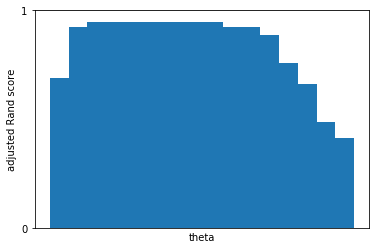

In [34]:
plt.figure(0)
plt.bar(thetas, res)
plt.xticks([])
plt.yticks([0., 1.])
plt.xlabel('theta')
plt.ylabel('adjusted Rand score')
